# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
# !pip install implicit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender
from tqdm import tqdm

tqdm.pandas()

In [3]:
data = pd.read_csv('../raw_data/retail_train.csv')
item_features = pd.read_csv('../raw_data/product.csv')
user_features = pd.read_csv('../raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# Если я не ошибаюсь, предобработку данных на датасете 
# лучше выполнять до разделения, выборки. 
# data = prefilter_items(data, item_features=item_features, take_n_popular=5000)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

user_id    basket_id  day  item_id  quantity  sales_value  store_id  \
0     2375  26984851472    1  1004906         1         1.39       364   
1     2375  26984851472    1  1033142         1         0.82       364   

   retail_disc  trans_time  week_no  coupon_disc  coupon_match_disc  
0         -0.6        1631        1          0.0                0.0  
1          0.0        1631        1          0.0                0.0

In [4]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [5]:
recommender = MainRecommender(data_train_lvl_1)

100%|██████████| 5001/5001 [00:00<00:00, 23764.88it/s]


In [6]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1037863, 951590, 1044078, 991546]

In [7]:
recommender.get_own_recommendations(2375, N=5)

[1068562, 1005935, 907099, 1112627, 1036501]

In [8]:
is_extend_with_top_popular=True
recommender.get_own_recommendations(user=2375, N=5, extend_with_top_popular=is_extend_with_top_popular)

[1068562, 1005935, 907099, 1112627, 1036501]

In [9]:
recommender.get_similar_items_recommendation(2375, N=5)

[889731, 1044078, 999207, 1062966, 9677366]

In [10]:
recommender.get_similar_users_recommendation(2375, N=5)

[1052155, 831125, 854133, 7147317, 911162]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [11]:
data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

user_id    basket_id  day  item_id  quantity  sales_value  store_id  \
1748540     1602  34748855121  503   999999         2         3.98       334   
1748542     1375  34748856592  503   849003         1         3.18       334   

         retail_disc  trans_time  week_no  coupon_disc  coupon_match_disc  
1748540          0.0         843       73          0.0                0.0  
1748542          0.0        1708       73          0.0                0.0

In [12]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']

result_lvl_1.head(2)

user_id                                             actual
0        1  [853529, 865456, 867607, 872137, 874905, 87524...
1        2  [15830248, 838136, 839656, 861272, 866211, 870...

In [13]:
# Убирем из тестовой выборки пользоватлей, которые отсутствуют в обучащей. 
# Определяем уникальных пользователей которые есть в тестовом датасете. 

result_lvl_1 = result_lvl_1[result_lvl_1['user_id'].isin(data_train_lvl_1['user_id'].unique())]
result_lvl_1['user_id'].count()

2084

In [14]:
N=50
result_lvl_1['similar_items_recomender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N))

result_lvl_1['als_recmender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=N))

result_lvl_1['own_recomender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))

# Дополняем недостающие товары популярными.
is_extend_with_top_popular=True
result_lvl_1['own_recomender_extend'] = result_lvl_1['user_id'].apply(lambda x:
 recommender.get_own_recommendations(x, N=N, extend_with_top_popular=is_extend_with_top_popular))

In [15]:
N=50
precision_dic = {'method':[], 'precission':[] }

column_names = ['similar_items_recomender',
                'als_recmender',
                'own_recomender',
                'own_recomender_extend'
]
for column_name in column_names:
    precision_dic['method'].append(column_name)
    precision_dic['precission'].append(result_lvl_1.apply(lambda x: precision_at_k(x[column_name], x['actual'],  N), axis=1).mean()) 

pd.DataFrame(precision_dic)

method  precission
0  similar_items_recomender    0.057342
1             als_recmender    0.080163
2            own_recomender    0.118695
3     own_recomender_extend    0.118695

In [16]:
N=50
precision_dic = {'method':[], 'recall':[] }

column_names = ['similar_items_recomender',
                'als_recmender',
                'own_recomender',
                'own_recomender_extend'
]
for column_name in column_names:
    precision_dic['method'].append(column_name)
    precision_dic['recall'].append(result_lvl_1.apply(lambda x: recall_at_k(x[column_name], x['actual'],  N), axis=1).mean()) 

pd.DataFrame(precision_dic)

method    recall
0  similar_items_recomender  0.061504
1             als_recmender  0.064782
2            own_recomender  0.113664
3     own_recomender_extend  0.113664

**B)**\* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

In [17]:
def get_metrics(metric,values):
    metric_values = []
    is_extend_with_top_popular=True
    for k in tqdm(values):
        result_lvl_1[f'own_recomender_{k}'] = result_lvl_1['user_id'].apply(lambda x: recommender. \
        get_own_recommendations(x, N=k,extend_with_top_popular=is_extend_with_top_popular))
        metric_values.append(result_lvl_1.apply(lambda x: metric(x[f'own_recomender_{k}'],
        x['actual'],  k), axis=1).mean()) 
    return metric_values


In [18]:
values = [5, 10, 20, 50, 100, 200, 500]

recall = get_metrics(recall_at_k, values) # <-- Recall тута !^_^!

100%|██████████| 7/7 [00:26<00:00,  3.81s/it]


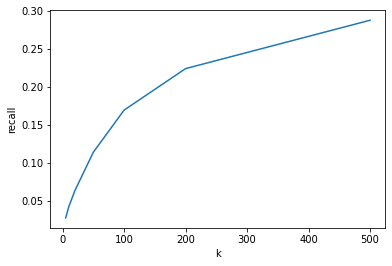

In [19]:
plt.plot(values, recall)
plt.ylabel('recall')
plt.xlabel('k')
plt.show()

**C)*** Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

Для того чтобы ответить на этот вопрос, построим, дополнительно, график precision_at_k.

In [20]:
precision = get_metrics(precision_at_k, values)

100%|██████████| 7/7 [00:26<00:00,  3.80s/it]


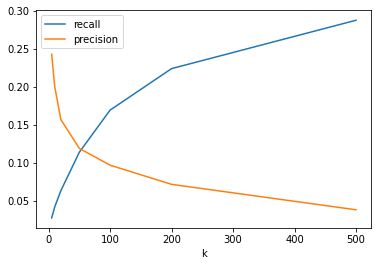

In [21]:
plt.plot(values, recall, label='recall')
plt.xlabel('k')
plt.plot(values, precision, label='precision')
plt.legend()
plt.show()

Видно, что с увеличением к-ва элементов recall  ростет, а precision уменьшается. Выбор значения k во монгом зависит от задачи, все завист от того какой параметр мы хотим максимизировать. 
Но, в общем случаем оптимальне значение k находится в месте пересечения графиков precision и recall, т.е. ~ 50.

### Задание 2.

Обучите модель 2-ого уровня, при этом:  
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар  
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2  
    - Вырос ли precision@5 при использовании двухуровневой модели?  

In [22]:
# Попробуем сперва пострить предсказания на одноуровневой модели.

In [23]:
# result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
# result_lvl_2.columns=['user_id', 'actual']

# result_lvl_2 = result_lvl_2[result_lvl_2['user_id'].isin(data_train_lvl_1['user_id'].unique())]
# result_lvl_2['user_id'].count()
# result_lvl_2.head(2)

In [24]:
def perpare_lvl2(data,N=50):
    users_lvl_2 = pd.DataFrame(data['user_id'].unique())
    users_lvl_2.columns = ['user_id']

    # Пока только warm start
    users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(data_train_lvl_1['user_id'].unique())]

    # Заполняем кандидатов, на основе предсказания модели 1-го уровня.
    users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))
    # test_users = data
    s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'item_id'
    # Это кандидаты. (т.е. предпологаемые покупки совершенные на основе предсказаний.)
    users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
    users_lvl_2['drop'] = 1  # фиктивная переменная

    # Создадим таблицу с реальными покупками user-ов. 
    targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
    targets_lvl_2['target'] = 1  # тут только покупки 

    # Объединим предпологаемые покупки с реальными, совершенными user-ами.
    targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

    # В результате, напротив товаров, в редсказании которых мы ошиблись, 
    # будет стоять Nan. Заполним их  нулями.  
    targets_lvl_2['target'].fillna(0, inplace= True)
    targets_lvl_2.drop('drop', axis=1, inplace=True)
    targets_lvl_2['target'].mean() #Угадали примерно 17% покупок.

    # Добавим к нашему датасету фичи user-ов и item-ов.
    targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
    targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

    X_ = targets_lvl_2.drop('target', axis=1)
    y_ = targets_lvl_2[['target']]
    return X_, y_ 

In [25]:
X_train, y_train = perpare_lvl2(data_train_lvl_2)
X_test, y_test = perpare_lvl2(data_val_lvl_2)

In [26]:
X_train.head(2)

user_id  item_id  manufacturer department     brand commodity_desc  \
0     2070   834103          2224    GROCERY  National    SOFT DRINKS   
1     2070   834103          2224    GROCERY  National    SOFT DRINKS   

               sub_commodity_desc curr_size_of_product age_desc  \
0  SFT DRNK SNGL SRV BTL CARB (EX                20 OZ    45-54   
1  SFT DRNK SNGL SRV BTL CARB (EX                20 OZ    45-54   

  marital_status_code income_desc homeowner_desc hh_comp_desc  \
0                   U      50-74K        Unknown      Unknown   
1                   U      50-74K        Unknown      Unknown   

  household_size_desc kid_category_desc  
0                   1      None/Unknown  
1                   1      None/Unknown

In [27]:
cat_feats = X_train.columns[2:].tolist()

X_train[cat_feats] = X_train[cat_feats].astype('category')

X_test[cat_feats] = X_test[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [28]:
y_train.mean()

target    0.178224
dtype: float64

In [ ]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=7,
                     categorical_column=cat_feats
                     )
                     
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)[:,1]

In [30]:
train_preds

array([0.70952246, 0.70952246, 0.70952246, ..., 0.20452483, 0.23743976,
       0.19333136])

In [31]:
y_train['target'].values

array([1., 1., 1., ..., 0., 0., 0.])

In [32]:
precision_at_k(train_preds, y_train['target'].values, k=5)

0.0

In [33]:
x_train_t = X_train.copy()

In [34]:
train_preds.min(), train_preds.max()

(0.0014968461992007204, 0.9267339841873625)

In [35]:
x_train_t['predict'] = train_preds

In [36]:
x_train_t['true'] = y_train['target'].values

In [37]:
# result = X_train.groupby('user_id')['item_id'].unique().reset_index()
# result.columns=['user_id', 'actual']
# result.head(2)

In [38]:
x_train_t.head(2)

user_id  item_id manufacturer department     brand commodity_desc  \
0     2070   834103         2224    GROCERY  National    SOFT DRINKS   
1     2070   834103         2224    GROCERY  National    SOFT DRINKS   

               sub_commodity_desc curr_size_of_product age_desc  \
0  SFT DRNK SNGL SRV BTL CARB (EX                20 OZ    45-54   
1  SFT DRNK SNGL SRV BTL CARB (EX                20 OZ    45-54   

  marital_status_code income_desc homeowner_desc hh_comp_desc  \
0                   U      50-74K        Unknown      Unknown   
1                   U      50-74K        Unknown      Unknown   

  household_size_desc kid_category_desc   predict  true  
0                   1      None/Unknown  0.709522   1.0  
1                   1      None/Unknown  0.709522   1.0

In [39]:
# x_train_t.loc[(x_train_t['user_id']==1)] 

In [40]:
result = x_train_t.sort_values('predict', ascending=False)

In [41]:
len(result)

111382

In [42]:
result_gr  = result.groupby('user_id')['item_id'].unique().reset_index()

In [43]:
items = result.loc[(result['user_id']==1),'item_id'].values[0]

In [ ]:
# Топ покупок каждого юзера
self.top_purchases = data.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
self.top_purchases.sort_values('quantity', ascending=False, inplace=True)
self.top_purchases = self.top_purchases[self.top_purchases['item_id'] != 999999]

# Топ покупок по всему датасету
self.overall_top_purchases = data.groupby('item_id')['quantity'].count().reset_index()
self.overall_top_purchases.sort_values('quantity', ascending=False, inplace=True)
self.overall_top_purchases = self.overall_top_purchases[self.overall_top_purchases['item_id'] != 999999]
self.overall_top_purchases = self.overall_top_purchases.item_id.tolist()

In [ ]:
def _extend_with_top_popular(self, recommendations, N=5):
    """Если кол-во рекоммендаций < N, то дополняем их топ-популярными"""

    if len(recommendations) < N:
        recommendations.extend(self.overall_top_purchases[:N])
        recommendations = recommendations[:N]

    return recommendations

In [44]:
def get_items_1(items, user_id, item_name):
    items_list = []
    # true_list = []
    # items = data.loc[(data['user_id']==user_id),'item_id'].values[0]
    # items_list = .append(x_train_t.loc[((x_train_t['user_id']==user_id) & (x_train_t['item_id']==item)),item_name].mean())

    for item in items:
        items_list.append(x_train_t.loc[((x_train_t['user_id']==user_id) & (x_train_t['item_id']==item)),item_name].mean())
        # true_list.append(x_train_t.loc[((x_train_t['user_id']==1) & (x_train_t['item_id']==item)),'true'].mean())
    return items_list

In [59]:
def get_items(data, user_id, item_name):
    items_list = []
    items = data.loc[(data['user_id']==user_id),'item_id'].values[0]

    for item in items:
        flag = x_train_t.loc[((x_train_t['user_id']==user_id) & (x_train_t['item_id']==item)),item_name].mean()
        if np.round(flag):
            items_list.append(item)
    return items_list

In [60]:
item_name = 'predict'
result_gr[item_name] = result_gr['user_id'].progress_apply(lambda x : get_items(result_gr, x, item_name) )

100%|██████████| 2084/2084 [01:14<00:00, 28.04it/s]


In [61]:
item_name = 'true'
result_gr[item_name] = result_gr['user_id'].progress_apply(lambda x : get_items(result_gr, x, item_name) )

100%|██████████| 2084/2084 [01:17<00:00, 26.92it/s]


In [74]:
result_gr.head(3)

user_id                                            item_id  \
0        1  [8293439, 9655212, 1082212, 898121, 820165, 55...   
1        2  [900072, 898847, 838136, 1076580, 889511, 1108...   
2        4  [1082185, 1029743, 1106523, 1070820, 990797, 9...   

                               predict  \
0  [8293439, 9655212, 1082212, 898121]   
1                                   []   
2                                   []   

                                                true  
0  [8293439, 9655212, 1082212, 820165, 5577022, 9...  
1  [838136, 1082185, 852864, 899624, 885023, 1106...  
2                                           [962229]

In [72]:
# x_train_t.loc[(x_train_t['user_id']==4)]

In [63]:
prd = result_gr.loc[0].predict

In [64]:
type(prd[0])

numpy.int64

In [56]:
# prd = np.round(prd)[:5]

In [65]:
tr = result_gr.loc[0].true

In [66]:
type(tr[0])

numpy.int64

In [67]:
def precision_at(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    # print(len(bought_list))
    # print(len(recommended_list))
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    # print(len(flags))
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

precision_at(prd,tr,5)

0.75

In [ ]:
precisions=[]
for res in tqdm(result_gr.iterrows()):
    user_id = res[1]['user_id']
    # item_ids = res[1]['item_id']
    predict = get_items(result_gr, user_id, 'predict')
    true = get_items(result_gr, user_id, 'true')
    precisions.append(precision_at_k(predict,true,5))

In [ ]:
np.mean(precisions)

In [45]:
result_gr.head(2)

user_id                                            item_id
0        1  [8293439, 9655212, 1082212, 898121, 820165, 55...
1        2  [900072, 898847, 838136, 1076580, 889511, 1108...

In [49]:
precisions=[]
for res in tqdm(result_gr.iterrows()):
    user_id = res[1]['user_id']
    item_ids = res[1]['item_id']
    predict = get_items_1(item_ids, user_id, 'predict')
    true = get_items_1(item_ids, user_id, 'true')
    precisions.append(precision_at_k(predict,true,5))

2084it [11:58,  2.90it/s]


In [53]:
precisions[0]

0.0

In [52]:
np.max(precisions)

0.0

In [50]:
np.mean(precisions)

0.0

In [160]:
result_1 = pd.merge(result['item_id'].unique().reset_index(), result['predict'].unique().reset_index(),on=['user_id'], how='right')

In [161]:
result_1 = pd.merge(result_1, result['true'].unique().reset_index(),on=['user_id'], how='right')

user_id                                            item_id  \
0           1  [8293439, 9655212, 1082212, 898121, 820165, 55...   
1           2  [900072, 898847, 838136, 1076580, 889511, 1108...   
2           4  [1082185, 1029743, 1106523, 1070820, 990797, 9...   
3           6  [1119051, 1063207, 825541, 5580166, 900802, 87...   
4           7  [1110039, 849505, 9420337, 1093571, 1135044, 8...   
...       ...                                                ...   
2079     2496  [1020729, 831509, 1014915, 992870, 926465, 102...   
2080     2497  [1135834, 834484, 6979005, 883202, 1019247, 82...   
2081     2498  [905436, 5577022, 1076580, 897752, 1028473, 10...   
2082     2499  [901403, 910745, 844441, 1132280, 9575582, 833...   
2083     2500  [7409970, 993617, 1090017, 1088393, 831536, 82...   

                                                predict        true  
0     [0.6573410376173984, 0.6521116432110966, 0.578...  [1.0, 0.0]  
1     [0.35601292776761434, 0.3543842798650611, 0.35...  [0.0, 1.0]  
2     [0.2618123369403981, 0.19313170039609787, 0.18...  [0.0, 1.0]  
3     [0.42796986558845873, 0.3271599329425697, 0.30...  [1.0, 0.0]  
4     [0.4999662141176107, 0.4504884497726511, 0.442...  [0.0, 1.0]  
...                                                 ...         ...  
2079  [0.6953721210742708, 0.43947926505727386, 0.39...  [0.0, 1.0]  
2080  [0.5505758762685677, 0.4270014996082897, 0.422...  [1.0, 0.0]  
2081  [0.46037776854002, 0.42352729317576415, 0.4010...  [0.0, 1.0]  
2082  [0.5327829788125864, 0.2884202426738945, 0.274...  [1.0, 0.0]  
2083  [0.4054481654810208, 0.3766481576792912, 0.339...  [0.0, 1.0]  

[2084 rows x 4 columns]

In [ ]:
result.columns=['user_id', 'actual']
result.head(2)

In [77]:
x_train_t['item_id'].unique() # actual нужно брать из этого списка!!!

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Топ покупок по всему датасету
self.overall_top_purchases = data.groupby('item_id')['quantity'].count().reset_index()
self.overall_top_purchases.sort_values('quantity', ascending=False, inplace=True)

In [ ]:
# отсортируем товары по по популярности. 

In [69]:
x_train_t

user_id  item_id manufacturer department     brand  \
0          2070   834103         2224    GROCERY  National   
1          2070   834103         2224    GROCERY  National   
2          2070   834103         2224    GROCERY  National   
3          2070   834103         2224    GROCERY  National   
4          2070   834103         2224    GROCERY  National   
...         ...      ...          ...        ...       ...   
111377     1745  1082185            2    PRODUCE  National   
111378     1745  1106523           69    GROCERY   Private   
111379     1745  1133018           69    GROCERY   Private   
111380     1745   981760           69    GROCERY   Private   
111381     1745   923746           69    GROCERY   Private   

             commodity_desc              sub_commodity_desc  \
0               SOFT DRINKS  SFT DRNK SNGL SRV BTL CARB (EX   
1               SOFT DRINKS  SFT DRNK SNGL SRV BTL CARB (EX   
2               SOFT DRINKS  SFT DRNK SNGL SRV BTL CARB (EX   
3               SOFT DRINKS  SFT DRNK SNGL SRV BTL CARB (EX   
4               SOFT DRINKS  SFT DRNK SNGL SRV BTL CARB (EX   
...                     ...                             ...   
111377       TROPICAL FRUIT                         BANANAS   
111378  FLUID MILK PRODUCTS           FLUID MILK WHITE ONLY   
111379  FLUID MILK PRODUCTS           FLUID MILK WHITE ONLY   
111380                 EGGS                  EGGS - X-LARGE   
111381                 EGGS                    EGGS - LARGE   

       curr_size_of_product age_desc marital_status_code income_desc  \
0                     20 OZ    45-54                   U      50-74K   
1                     20 OZ    45-54                   U      50-74K   
2                     20 OZ    45-54                   U      50-74K   
3                     20 OZ    45-54                   U      50-74K   
4                     20 OZ    45-54                   U      50-74K   
...                     ...      ...                 ...         ...   
111377                40 LB    45-54                   A   Under 15K   
111378                 1 GA    45-54                   A   Under 15K   
111379                         45-54                   A   Under 15K   
111380                 1 DZ    45-54                   A   Under 15K   
111381                18 CT    45-54                   A   Under 15K   

       homeowner_desc hh_comp_desc household_size_desc kid_category_desc  \
0             Unknown      Unknown                   1      None/Unknown   
1             Unknown      Unknown                   1      None/Unknown   
2             Unknown      Unknown                   1      None/Unknown   
3             Unknown      Unknown                   1      None/Unknown   
4             Unknown      Unknown                   1      None/Unknown   
...               ...          ...                 ...               ...   
111377        Unknown  Single Male                   2      None/Unknown   
111378        Unknown  Single Male                   2      None/Unknown   
111379        Unknown  Single Male                   2      None/Unknown   
111380        Unknown  Single Male                   2      None/Unknown   
111381        Unknown  Single Male                   2      None/Unknown   

         predict  
0       0.709522  
1       0.709522  
2       0.709522  
3       0.709522  
4       0.709522  
...          ...  
111377  0.386055  
111378  0.328104  
111379  0.204525  
111380  0.237440  
111381  0.193331  

[111382 rows x 16 columns]

In [57]:
test_preds = lgb.predict(X_test)

In [59]:
precision_at_k(test_preds, y_test, k=5)

17262.0

In [ ]:
recall_at_k(train_preds, y_train, k=5)

0.1782244886965578

In [ ]:
# x_test

In [ ]:
# y_test

In [ ]:
def perpare_lvl2(data,N=50):
    users_lvl_2 = pd.DataFrame(data['user_id'].unique())
    users_lvl_2.columns = ['user_id']

    # Пока только warm start
    users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(data_train_lvl_1['user_id'].unique())]

    # Заполняем кандидатов, на основе предсказания модели 1-го уровня.
    users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))
    
    # test_users = data
    s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'item_id'

    # Это кандидаты. (т.е. предпологаемые покупки совершенные на основе предсказаний.)
    users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
    users_lvl_2['drop'] = 1  # фиктивная переменная

    # Создадим таблицу с реальными покупками user-ов. 
    targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
    targets_lvl_2['target'] = 1  # тут только покупки 

    # Объединим предпологаемые покупки с реальными, совершенными user-ами.
    targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

    # В результате, напротив товаров, в редсказании которых мы ошиблись, 
    # будет стоять Nan. Заполним их  нулями.  
    targets_lvl_2['target'].fillna(0, inplace= True)
    targets_lvl_2.drop('drop', axis=1, inplace=True)
    targets_lvl_2['target'].mean() #Угадали примерно 17% покупок.

    # Добавим к нашему датасету фичи user-ов и item-ов.
    targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
    targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

    X_ = targets_lvl_2.drop('target', axis=1)
    y_ = targets_lvl_2[['target']]
    
    return X_, y_ 

In [ ]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']

result_lvl_1.head(2)

result_lvl_1 = result_lvl_1[result_lvl_1['user_id'].isin(data_train_lvl_1['user_id'].unique())]
result_lvl_1['user_id'].count()

top_purchases = data.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
top_purchases.sort_values('quantity', ascending=False, inplace=True)
top_purchases = top_purchases[top_purchases['item_id'] != 999999]

N=50
result_lvl_1['similar_items_recomender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N))

result_lvl_1['als_recmender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=N))

result_lvl_1['own_recomender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))

# Дополняем недостающие товары популярными.
is_extend_with_top_popular=True
result_lvl_1['own_recomender_extend'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N, extend_with_top_popular=is_extend_with_top_popular))

N=50
precision_dic = {'method':[], 'precission':[] }

column_names = ['similar_items_recomender',
                'als_recmender',
                'own_recomender',
                'own_recomender_extend'
]
for column_name in column_names:
    precision_dic['method'].append(column_name)
    precision_dic['precission'].append(result_lvl_1.apply(lambda x: precision_at_k(x[column_name], x['actual'],  N), axis=1).mean()) 

pd.DataFrame(precision_dic)

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 